<a href="https://colab.research.google.com/github/hemantnyadav/skincancer-identification/blob/main/Skin_Cencer_inceptionv3_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

{}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d  hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 92% 91.0M/98.7M [00:01<00:00, 80.2MB/s]
100% 98.7M/98.7M [00:01<00:00, 77.6MB/s]


In [ ]:
#!unzip melanoma-skin-cancer-dataset-of-10000-images.zip

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D

In [ ]:
# Define the paths to the train and test directories
train_dir = 'melanoma_cancer_dataset/train'
test_dir = 'melanoma_cancer_dataset/test'

In [ ]:
# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 128

# Define the data generators for the train and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Scale the pixel values from 0-255 to 0-1
    rotation_range=40,      # Randomly rotate the images up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the images horizontally up to 20% of the width
    height_shift_range=0.2, # Randomly shift the images vertically up to 20% of the height
    #shear_range=0.2,        # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom in on the images
    horizontal_flip=True,   # Randomly flip the images horizontally
    fill_mode='nearest')    # Fill any empty pixels with the nearest available pixel

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,              # Path to the train directory
    target_size=(img_width, img_height), # Resize the images to the specified dimensions
    batch_size=batch_size,
    class_mode='binary') 
test_generator = test_datagen.flow_from_directory(
    test_dir,               # Path to the test directory
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device(device_name):

    base_model = InceptionV3(
      weights='imagenet',
      include_top=False,
      input_shape=(img_width, img_height, 3))
    for layer in base_model.layers:
      layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))        # Create a TensorFlow model.
    
    opt = Adam(learning_rate=0.0001)

    model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']) # Compile the model on the GPU.
# Once the model has been created and compiled on the GPU, it can be
# trained as per usual.

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, verbose=1)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator, 
    callbacks=[early_stop],
    verbose=1)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/25
76/76 [==============================] - 151s 2s/step - loss: 0.5325 - accuracy: 0.7327 - val_loss: 0.3607 - val_accuracy: 0.8540
Epoch 2/25
76/76 [==============================] - 126s 2s/step - loss: 0.4133 - accuracy: 0.8187 - val_loss: 0.3308 - val_accuracy: 0.8720
Epoch 3/25
76/76 [==============================] - 127s 2s/step - loss: 0.3813 - accuracy: 0.8335 - val_loss: 0.3190 - val_accuracy: 0.8780
Epoch 4/25
76/76 [==============================] - 126s 2s/step - loss: 0.3673 - accuracy: 0.8343 - val_loss: 0.3130 - val_accuracy: 0.8750
Epoch 5/25
76/76 [==============================] - 126s 2s/step - loss: 0.3561 - accuracy: 0.8483 - val_loss: 0.3137 - val_accuracy: 0.8670
Epoch 6/25
76/76 [==============================] - 127s 2s/step - loss: 0.3436 - accuracy: 0.8562 - val_loss: 0.3045 - val_accuracy: 0.8870
Epoch 7/25
76/76 [==============================] - 125s 2s/step - loss: 0.3332 - accurac

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

8/8 [==============================] - 3s 386ms/step - loss: 0.2690 - accuracy: 0.8940
Test accuracy: 0.8939999938011169


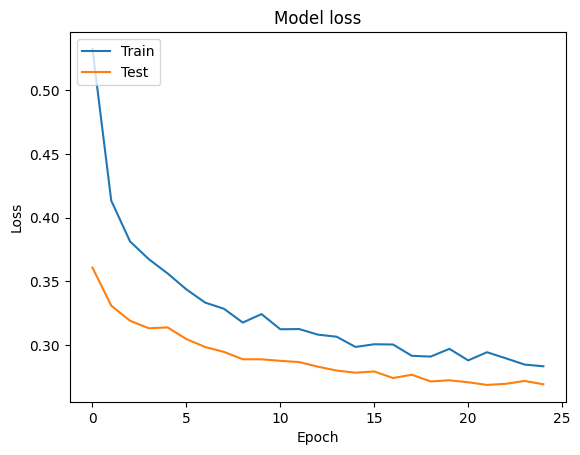

In [ ]:
# Plot loss values vs epoch
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('skincancer_inception1_GPU.h5')

In [ ]:
test_pred = model.predict(test_generator)

8/8 [==============================] - 4s 542ms/step


In [ ]:
y_test_pred = ( test_pred> 0.5).astype("int32")  
y_test_true =  np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())]) 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pred, y_test_true)

array([[267, 271],
       [233, 229]])